# Model Exploration

same configuration swapping test and val ds

## Imports

In [5]:
# Generics dependencies
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from random import randint
from glob import glob
import splitfolders

# Tensorflow dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, 
    Dropout, Rescaling, BatchNormalization, Resizing,
    RandomFlip, RandomCrop, RandomContrast, RandomBrightness,
    RandomRotation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow.config.threading import set_inter_op_parallelism_threads, set_intra_op_parallelism_threads
from tensorflow_addons.metrics import F1Score

import tensorflow as tf
import tensorboard


### Configure GPU

[Procedure for handling GPU](https://www.tensorflow.org/install/gpu)

In [6]:
gpus = list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Multithreading

In [7]:
num_threads = 8  # 0 = let tensorflow decide the number of threads
set_intra_op_parallelism_threads(num_threads)
set_inter_op_parallelism_threads(num_threads)

### Data samples

../data/03/fer_2013/train/neutral/Training_25837662.jpg
../data/03/fer_2013/train/neutral/Training_71832734.jpg
../data/03/fer_2013/train/happy/Training_41739162.jpg


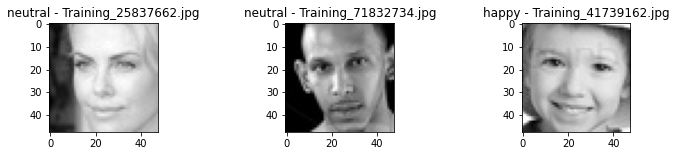

In [8]:

train_files =  glob('../data/03/fer_2013/train/*/**.jpg')
test_files =  glob('../data/03/fer_2013/test/*/**.jpg')

train_length = len(train_files)
plt.figure(figsize=(12, 2))

for i in range(3):
    file = train_files[randint(0, len(train_files) -1 )]
    print(file)
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    ax = plt.subplot(1, 3, i + 1)
    plt.title(title_base)
    plt.imshow(image, cmap=cm.gray)    
plt.show()

In [30]:
# import matplotlib.image as mpimg

# face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
# base_dim=48

# def apply_grayscale_mask(img):
    
#     grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     mask = np.array([list(map(lambda x: 1 if x < 240 else 0, row)) for row in grayscale_image])        
#     return np.where(mask[...], grayscale_image[...], 0)

# def detect_face(file):
#     img = mpimg.imread(file)
#     if len(img.shape) == 3:
#         img = apply_grayscale_mask(img)
#     faces = face_detector.detectMultiScale(img, scaleFactor=1.3, minNeighbors=0)
#     if len(faces > 0):
#         x, y, w, h = faces[0]
#         if w > 180 and h > 180:
#             roi = img[y:y + h, x:x + w]
#             cropped_img = cv2.resize(roi, (base_dim, base_dim))
#             return cropped_img
#     return []

In [10]:
# original_folder= '../data/03/fer_13'
# rescale_folder='../data/03/resized'

# import os
# from tqdm import tqdm
# from PIL import Image
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg


# for split in os.listdir(original_folder):
#     print(f"[INFO] Processing {split} folder")
#     for categories in os.listdir(os.path.join(original_folder, split)):
#         for file in tqdm(os.listdir(os.path.join(original_folder, split, categories))):
#             input_file = os.path.join(original_folder, split, categories, file)
#             output_file = os.path.join(rescale_folder, split, categories, file)
#             if not os.path.isfile(output_file):
#                 img = detect_face(input_file)
#                 if len(img) > 0: 
#                     dest = os.path.join(rescale_folder, split, categories)
#                     if not os.path.exists(dest):
#                         os.makedirs(dest)
#                     cv2.imwrite(os.path.join(dest, file), img)



# Creating datasets

In [27]:
# from functions import configure_for_performance

data_folder = '../data/03/fer_2013'
base_dim = 48
batch_size = 64
seed = 1111

# splitfolders.ratio("../data/02/fer_2013", output="../data/03/fer_2013", seed=seed, ratio=(.8, .1, .1))

datasets = []
for split in ['train', 'val', 'test']:
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_folder, split),
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(base_dim, base_dim),
        shuffle=True,
        seed=seed,
    )
    # ds = configure_for_performance(ds)
    datasets.append(ds)
    
train_ds, val_ds, test_ds = datasets

Found 28706 files belonging to 7 classes.
Found 3585 files belonging to 7 classes.
Found 3596 files belonging to 7 classes.


In [ ]:
# from matplotlib import cm

# num = 4

# fig, ax = plt.subplots(num, 2, figsize=(12, 12))

# for i in range(num):
#     file = train_files[randint(0, len(train_files) -1 )]
#     im = mpimg.imread(file)
#     ax[i][0].imshow(im, cmap=cm.gray)
#     ax[i][1].imshow(detect_face(file), cmap=cm.gray) 
# plt.show()


In [16]:
%xdel datasets

## 1st CNN + Tensorflow Datasets and multithreading
### building model 

In [32]:
factor= .2

data_transformation = Sequential([
    RandomRotation(factor, seed=seed),
    # Resizing(base_dim, base_dim, crop_to_aspect_ratio=True),
    RandomFlip(mode="horizontal", seed=seed), 
    RandomCrop(base_dim * factor, base_dim * factor, seed=seed), 
    RandomContrast(factor, seed=seed), 
    RandomBrightness(factor, seed=seed),
])

dropout = .25
kernel_size = (3, 3)
pool_size = (2, 2)


model = Sequential([
    # data_transformation,
    Rescaling(1. / 255, input_shape=(base_dim, base_dim, 1)),
    Conv2D(32, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(dropout),
    Conv2D(128, kernel_size=kernel_size, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=pool_size),
    Conv2D(128, kernel_size=kernel_size, activation='relu'),
    MaxPooling2D(pool_size=pool_size),
    BatchNormalization(),
    Dropout(dropout),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(.5),
    Dense(7, activation='softmax'),
])
model.build()
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-7), metrics=[F1Score(7, average='macro')])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)       

### Set callbacks

+ 1.0 factor .1 data aug
+ 1.1 factor .2 no_data_aug
+ 1.2 kernel size (3, 3)
+ 1.3 kernel size (5, 5)
+ 2.0 kernel size (3, 3), input_shape (96, 96)
+ 2.1  kernel size (3, 3), dense 1024 -> 512
+ 

In [34]:
exp_name = 'fer_2013_1.0'

lr_scheduler_cb = LearningRateScheduler(
    lambda epoch, lr: lr * 0.9 if epoch > 3 else lr
)

tensorboard_cb = TensorBoard(
    os.path.join('../models/logs/', exp_name), 
    histogram_freq=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [
    tensorboard_cb,
    lr_scheduler_cb,
    reduce_lr_cb,
    early_stopping_cb
]

In [35]:
from datetime import timedelta
from time import time

start = time()

history = model.fit(
    train_ds,
    # steps_per_epoch=len(train_files) // batch_size,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks,
    workers=num_threads,
    use_multiprocessing=True
)

end = time()

duration = timedelta(seconds=(end - start))

print(f"[INFO] Process time : {duration}")

Epoch 1/100
449/449 [==============================] - 30s 64ms/step - loss: 1.8604 - f1_score: 0.3059 - val_loss: 1.6750 - val_f1_score: 0.2580 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 28s 62ms/step - loss: 1.3476 - f1_score: 0.4185 - val_loss: 1.2617 - val_f1_score: 0.4496 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 28s 62ms/step - loss: 1.2138 - f1_score: 0.4805 - val_loss: 1.1934 - val_f1_score: 0.4724 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 28s 62ms/step - loss: 1.1321 - f1_score: 0.5255 - val_loss: 1.1596 - val_f1_score: 0.5181 - lr: 0.0010
Epoch 5/100
449/449 [==============================] - 28s 62ms/step - loss: 1.0440 - f1_score: 0.5661 - val_loss: 1.2884 - val_f1_score: 0.4991 - lr: 9.0000e-04
Epoch 6/100
449/449 [==============================] - 28s 62ms/step - loss: 0.9493 - f1_score: 0.6192 - val_loss: 1.1032 - val_f1_score: 0.5699 - lr: 8.1000e-04
Epoch 7/100
449/449 [=======================

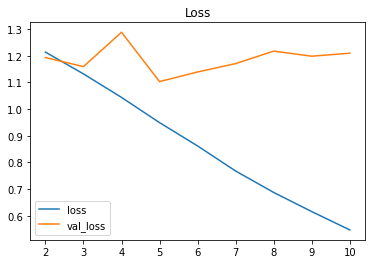

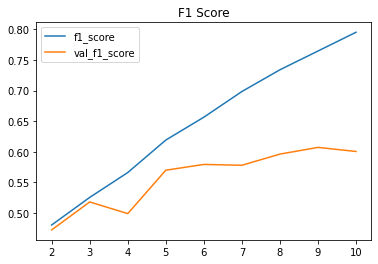

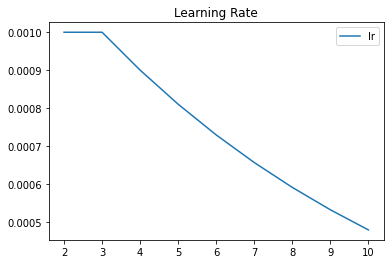

57/57 [==============================] - 1s 21ms/step - loss: 1.1165 - f1_score: 0.5488
Test loss : 1.1164542436599731   |   Test F1 Score : 0.5487525463104248


In [37]:
import pandas as pd

history_df = pd.DataFrame(history.history)
offset = 2
history_df[["loss", "val_loss"]][offset:].plot(title="Loss")
history_df[["f1_score", "val_f1_score"]][offset:].plot(title="F1 Score")
history_df[["lr"]][offset:].plot(title="Learning Rate")


plt.show()
test_loss, test_f1_score = model.evaluate(test_ds)
print(f"Test loss : {test_loss}   |   Test F1 Score : {test_f1_score}")

In [38]:
model_json = model.to_json()
if not os.path.exists(f'../models/{exp_name}'):
    os.makedirs(f'../models/{exp_name}/')
with open(f'../models/{exp_name}/model_{base_dim}x{base_dim}.json', 'w') as f:
    f.write(model_json)
    
model.save_weights(f'../models/{exp_name}/model_{base_dim}x{base_dim}.h5')

In [40]:
import joblib

joblib.dump(model, f"../models/{exp_name}.joblib")

INFO:tensorflow:Assets written to: ram://aa53dda2-f2d1-4a0a-92c7-2d72ee6f15a8/assets


INFO:tensorflow:Assets written to: ram://aa53dda2-f2d1-4a0a-92c7-2d72ee6f15a8/assets


['../models/fer_2013_1.0.joblib']

In [ ]:
history_df.head()

In [ ]:
from tensorflow.keras.models import model_from_json

base_dim = 48

with open(f'../models/{exp_name}/model_{base_dim}x{base_dim}.json', 'r') as f:
    loaded_json = f.read()

model = model_from_json(loaded_json)
model.load_weights(f'../models/{exp_name}/model_{base_dim}x{base_dim}.h5')

In [42]:
eval = model.evaluate(
    test_ds,
    max_queue_size=10,
    workers=num_threads,
    use_multiprocessing=True,
    callbacks=[tensorboard_cb]
)

57/57 [==============================] - 1s 21ms/step - loss: 1.1165 - f1_score: 0.5488


In [ ]:
print(labels)

In [ ]:
preds[2], trues[2]

In [ ]:
x, y = testing_ds

print(x)

In [ ]:
labels = test_ds.class_names
preds = [np.argmax(prediction) for prediction in predictions]
trues = [np.argmax(true) for true in np.concatenate([y for x, y in test_ds], axis=0)]
len(preds), len(trues)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(trues, preds))
print(confusion_matrix(trues, preds))

In [ ]:
pred_val = model.predict(
    x=val_ds,
    max_queue_size=10,
    workers=num_threads,
    use_multiprocessing=True,
    callbacks=[tensorboard_cb]
)

In [ ]:
labels = test_ds.class_names
preds = [labels[np.argmax(prediction)] for prediction in pred_val]
trues = [labels[np.argmax(true)] for true in np.concatenate([y for x, y in val_ds], axis=0)]
len(preds), len(trues)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(trues, preds))
print(confusion_matrix(trues, preds))

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(trues, preds), annot=True, xticklabels=labels, yticklabels=labels)

In [ ]:
from tensorflow.keras.models import model_from_json

base_dim = 48

with open(f'../models/{exp_name}/model_{base_dim}x{base_dim}.json', 'r') as f:
    loaded_json = f.read()

model = model_from_json(loaded_json)
model.load_weights(f'../models/{exp_name}/model_{base_dim}x{base_dim}.h5')


### Preprocessing steps

In [ ]:
from random import choices
from matplotlib import cm

demo_imgs = choices(train_files, k=3)

# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(4, 3, figsize=(18, 16))
for i in range(len(demo_imgs)):
    title_base = ' - '.join(file.split('/')[-2:])
    file = demo_imgs[i]
    img = mpimg.imread(file)
    # Original images
    ax[0][i].set_title(f"{title_base} - Original")
    ax[0][i].imshow(img)
    
    # Grayscale images
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ax[1][i].set_title(f"{title_base} - Grayscale")
    ax[1][i].imshow(grayscale_image, cmap=cm.gray)
    
    # Cropped images (face detection)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(grayscale_image, scaleFactor=1.3, minNeighbors=5)
    x, y, w, h = faces[0]
    roi_grayscale_img = grayscale_image[y:y + h, x:x + w]
    ax[2][i].set_title(f"{title_base} - ROI")
    ax[2][i].imshow(roi_grayscale_img, cmap=cm.gray)
    
    # Resized cropped images
    cropped_img = np.expand_dims(cv2.resize(roi_grayscale_img, (base_dim, base_dim)), -1)
    ax[3][i].set_title(f"{title_base} - Resized ROI")
    ax[3][i].imshow(cropped_img, cmap=cm.gray)
    
plt.show()

In [ ]:
from numpy import ndarray
import pandas as pd 
from tqdm import tqdm

test_files = glob(os.path.join(data_folder, 'test/*/**.jpg'))
columns = ['file', *list(emotions_dict.values()), 'true', 'predicted']

results = pd.DataFrame(columns=columns)
fail_face_recognition = []

for file in tqdm(test_files):
    img = mpimg.imread(file)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)
    if len(faces) > 0 :
        x, y, w, h = faces[0]
        roi_gray_img = gray_img[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_img, (48, 48)), -1), 0)
        predictions = model.predict(cropped_img, verbose=0)
    else:
        fail_face_recognition.append(file)
        predictions = model.predict(np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0), verbose=0)
    predicted  = np.argmax(predictions[0])
    row = [[file], *[[p] for p in predictions[0]], [file.split('/')[-2]], [emotions_dict[predicted]]]
    dict_row = dict(zip(columns, row))
    tmp_results = pd.DataFrame(dict_row)
    results = pd.concat([results, tmp_results])

In [ ]:
n_rows = len(fail_face_recognition) // 3 + 1

plt.figure(figsize=(18, 4 * n_rows))
index = 1

for i in range(len(fail_face_recognition)):
    file = fail_face_recognition[i]
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    plt.subplot(n_rows, 3, index)
    plt.title(title_base)
    plt.imshow(image)
    plt.subplot(n_rows, 3, index + 3)
    plt.title(f"{title_base} - resized")
    plt.imshow(cv2.resize(image, (48, 48)))
    index += 1
plt.show()

In [ ]:
results.sample(5)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(results['true'], results['predicted']))

In [ ]:
acc = results[results.true == results.predicted_revert].shape[0] / results.shape[0]
print(acc)

### 1st Model results

Train accuracy: 0.9966  
Validation accuracy: 0.9978
Test accuracy : 0.1407

In [ ]:
import seaborn as sns

confusion_matrix(results['true'], results['predicted_revert'])

### Test on video stream

In [ ]:
import os
from tabnanny import verbose
import cv2
# import skvideo.io
from glob import glob
import numpy as np
from random import randint

videos = glob('../data/test_face_recognition/*.mp4')
rdm_video = videos[randint(0, len(videos) - 1)]
cap = cv2.VideoCapture(rdm_video)
while True:
    success, frame = cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (640, 480))
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img, verbose=0)
        # print(dict(zip(emotions_dict.keys(), prediction[0])))
        max_index = int(np.argmax(prediction))
        cv2.putText(frame, emotions_dict[max_index], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow(f'Emotion Detection : {os.path.basename(rdm_video)}', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()